# Implementation of MTCNN - Multi-Task Cascaded Convolutional Networks

As a series of tutorials on the most popular deep learning algorithms for new-entry deep learning research engineers, MTCNN has been widely adopted in industry for human face detection task which is an essential step for subsquential face recognition and facial expression analysis. This tutorial is designed to explain how to implement the algorithm. In this tutorial, developers will learn how to build MTCNN model for face detection task.

MTCNN consists of three cascaded stages naming P-Net,R-Net,O-Net to predict face and landmark location. The whole architectures are showned below :

1. Proposal Network (P-Net) is intended to produce candiate windows and bounding box regression vectors. The candidate windows are firstly generated using different input image scales as an image pyramid so as to successfully detect various scaled faces in the image. The candidate windows collected with various scaled images are calibrated using bounding box regression vectors. NMS(non-maximum suppression) is applided to filter out highly overlapped candidates. 

2. Refine Network （R-Net): all candidate windows from P-net will feed into a more complet network -- R-Net, which will reject a large number of false candidates, perform bounding box regression calibration and NMS. 

3. Output Network (O-Net): The last network has one more convolutional layer than R-Net. It will further filter out non-face candidates and give the final detection windows, along with five facial landmarks ( be noted that only O-Net will be outputing landmarks, the architectures here from [Paper](https://kpzhang93.github.io/MTCNN_face_detection_alignment/paper/spl.pdf) is a little misleading...)

<img src="images/ipy_pic/network.jpeg"  width="400" style="float: left;">

The network outputs including bounding box regression vectors and landmark positions deserve more explainatons. They are normalized values. The regression represents the offsets of candidate window coordinates. For example, if the candidate window cooridnate is (x1, y1, x2, y2), the network output box regression is (tx1, ty1, tx2, ty2). Then the calibrated window cooridnate will be (x1+tx1*w, y1+ty1*h, x2+tx2*w, y2+ty2*h) where w = x2 - x1, h = y2 - y1. 

Similarly, the landmark positions for candidate window will be （x1 + w*x_landmarks), (y1+h*y_landmarks) where x_landmarks and y_landmarks are O-Net outputs for x axis and y axis respectively.

It should be also noted that P-Net is a fully convolutional network (FCN) which is able to accept any image sizes (The architecture here is misleading again. 12x12 image input is only for training). Applying P-Net for inference is equivalent, in some sense, to move 12x12 window with stride 2. The output of P-Net will be 2 feature maps such as face classification as [grid size x grid size x 2] and bounding box regression [grid size x grid size x 4]. The index of each cell will be converted to the candidate window coordinates on the test image. 

R-Net and O-Net have fully connected layers, and thus only accept 24x24 and 48x48 inputs. The proposed upstream candidate windows will be converted to square, cropped from test image and resized as 24x24 and 48x48 to feed into R-Net and O-Net respectively.

 # Code 
 
 Already , let's go to the exciting code part to implement MTCNN model !

In [1]:
from PIL import Image
import torch
from MTCNN_nets import PNet, RNet, ONet
import math 
import numpy as np
from utils.util import*
import cv2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

The MTCNN network is implemented using Pytorch with pretrained weights. Refer to the "MTCNN_nets.py" for details 

In [2]:
pnet = PNet().to(device)
rnet = RNet().to(device)
onet = ONet().to(device)

pnet.load_state_dict(torch.load('weights/pnet_Weights', map_location=lambda storage, loc: storage))
rnet.load_state_dict(torch.load('weights/rnet_Weights', map_location=lambda storage, loc: storage))
onet.load_state_dict(torch.load('weights/onet_Weights', map_location=lambda storage, loc: storage))

pnet.eval()
rnet.eval()
onet.eval()

image = cv2.imread('images/s_l.jpg')

### Set up some parameters
1. min_face_size denotes the minimum resized input image feeding into P-Net. The lower of this value, the more accurate model is, but in sacifice of speed. 
2. thresholds represent the face detection score threshold which increases as network cascades

In [3]:
min_face_size = 20.0
thresholds = [0.6, 0.7, 0.8]  # face detection thresholds
nms_thresholds = [0.7, 0.7, 0.7] # nms threshold

height, width, channel = image.shape
min_length = min(height, width)

Preprocessing the image before feeding the network. 

Arguments: img: a float numpy array of shape [h, w, c].
Returns: a float numpy array of shape [1, c, h, w].

In [4]:
def preprocess(img):
    img = img[:,:,::-1]
    img = np.asarray(img, 'float32')
    img = img.transpose((2, 0, 1))
    img = np.expand_dims(img, 0)
    img = (img - 127.5)*0.0078125
    return img

## Stage 1 

Let's define the NMS function to merge highly overlapped candidates 

In [5]:
def nms(boxes, overlap_threshold=0.5, mode='union'):
    """Non-maximum suppression.

    Arguments:
        boxes: a float numpy array of shape [n, 5],
            where each row is (xmin, ymin, xmax, ymax, score).
        overlap_threshold: a float number.
        mode: 'union' or 'min'.

    Returns:
        list with indices of the selected boxes
    """

    # if there are no boxes, return the empty list
    if len(boxes) == 0:
        return []

    # list of picked indices
    pick = []

    # grab the coordinates of the bounding boxes
    x1, y1, x2, y2, score = [boxes[:, i] for i in range(5)]

    area = (x2 - x1 + 1.0)*(y2 - y1 + 1.0)
    ids = np.argsort(score)  # in increasing order

    while len(ids) > 0:

        # grab index of the largest value
        last = len(ids) - 1
        i = ids[last]
        pick.append(i)

        # compute intersections of the box with the largest score with the rest of boxes

        # left top corner of intersection boxes
        ix1 = np.maximum(x1[i], x1[ids[:last]])
        iy1 = np.maximum(y1[i], y1[ids[:last]])

        # right bottom corner of intersection boxes
        ix2 = np.minimum(x2[i], x2[ids[:last]])
        iy2 = np.minimum(y2[i], y2[ids[:last]])

        # width and height of intersection boxes
        w = np.maximum(0.0, ix2 - ix1 + 1.0)
        h = np.maximum(0.0, iy2 - iy1 + 1.0)

        # intersections' areas
        inter = w * h
        if mode == 'min':
            overlap = inter/np.minimum(area[i], area[ids[:last]])
        elif mode == 'union':
            # intersection over union (IoU)
            overlap = inter/(area[i] + area[ids[:last]] - inter)

        # delete all boxes where overlap is too big
        ids = np.delete(
            ids,
            np.concatenate([[last], np.where(overlap > overlap_threshold)[0]])
        )

    return pick

### Here are the steps to code P-Net

1. The image is scaled by a factor 0.707 until the resized image reaches minimum face size. Each resized image will feed into PNet
2. Filter out the PNet output probs and offsets using face probability threshold
3. Convert cell index to cooridnates of candidate windows on test image, rescale bounding boxes back for rescaled input image, and apply a light nms with threshold 0.5
3. Build up the bounding_boxes as a format of number x 9, which 9 includes uncalibrated coordinates, score, offsets(bounding box regression vectors)

In [6]:
min_detection_size = 12
factor = 0.707  # sqrt(0.5)

# scales for scaling the image
scales = []

# scales the image so that minimum size that we can detect equals to minimum face size that we want to detect
m = min_detection_size / min_face_size
min_length *= m

factor_count = 0
while min_length > min_detection_size:
    scales.append(m * factor ** factor_count)
    min_length *= factor
    factor_count += 1

# it will be returned
bounding_boxes = []

with torch.no_grad():
    #run P-Net on different scales
    for scale in scales:
        sw, sh = math.ceil(width*scale), math.ceil(height*scale)
        img = cv2.resize(image, (sw, sh), interpolation=cv2.INTER_LINEAR)
        img = torch.FloatTensor(preprocess(img)).to(device)
        offset, prob = pnet(img)
        probs = prob.cpu().data.numpy()[0, 1, :, :] # probs: probability of a face at each sliding window
        offsets = offset.cpu().data.numpy()  # offsets: transformations to true bounding boxes
        # applying P-Net is equivalent, in some sense, to moving 12x12 window with stride 2
        stride, cell_size = 2, 12
        # indices of boxes where there is probably a face
        # returns a tuple with an array of row idx's, and an array of col idx's:
        inds = np.where(probs > thresholds[0])
        
        if inds[0].size == 0:
            boxes = None
        else:
            # transformations of bounding boxes
            tx1, ty1, tx2, ty2 = [offsets[0, i, inds[0], inds[1]] for i in range(4)]
            offsets = np.array([tx1, ty1, tx2, ty2])
            score = probs[inds[0], inds[1]]
            # P-Net is applied to scaled images
            # so we need to rescale bounding boxes back
            bounding_box = np.vstack([
            np.round((stride*inds[1] + 1.0)/scale),
            np.round((stride*inds[0] + 1.0)/scale),
            np.round((stride*inds[1] + 1.0 + cell_size)/scale),
            np.round((stride*inds[0] + 1.0 + cell_size)/scale),
            score, offsets])
            boxes = bounding_box.T
            keep = nms(boxes[:, 0:5], overlap_threshold=0.5)
            boxes[keep]
            
        bounding_boxes.append(boxes)
        
print('length of bounding_boxes list is', len(bounding_boxes))
print('bounding_boxes[0] shape is', bounding_boxes[0].shape)

length of bounding_boxes list is 9
bounding_boxes[0] shape is (159, 9)


Let's build up a function "calibrate_box" to calibrate the bounding boxes using offsets from network output.  

In [7]:
def calibrate_box(bboxes, offsets):
    
    """Transform bounding boxes to be more like true bounding boxes.
    'offsets' is one of the outputs of the nets.

    Arguments:
        bboxes: a float numpy array of shape [n, 5].
        offsets: a float numpy array of shape [n, 4].

    Returns:
        a float numpy array of shape [n, 5].
    """

    x1, y1, x2, y2 = [bboxes[:, i] for i in range(4)]
    w = x2 - x1 + 1.0
    h = y2 - y1 + 1.0
    w = np.expand_dims(w, 1)
    h = np.expand_dims(h, 1)

    translation = np.hstack([w, h, w, h])*offsets
    bboxes[:, 0:4] = bboxes[:, 0:4] + translation
    return bboxes

We have to then convert the calibrated bounding boxes to square form for feeding into subsquent nets

In [8]:
def convert_to_square(bboxes):
    
    """Convert bounding boxes to a square form.

    Arguments:
        bboxes: a float numpy array of shape [n, 5].

    Returns:
        a float numpy array of shape [n, 5],
            squared bounding boxes.
    """

    square_bboxes = np.zeros_like(bboxes)
    x1, y1, x2, y2 = [bboxes[:, i] for i in range(4)]
    h = y2 - y1 + 1.0
    w = x2 - x1 + 1.0
    max_side = np.maximum(h, w)
    square_bboxes[:, 0] = x1 + w*0.5 - max_side*0.5
    square_bboxes[:, 1] = y1 + h*0.5 - max_side*0.5
    square_bboxes[:, 2] = square_bboxes[:, 0] + max_side - 1.0
    square_bboxes[:, 3] = square_bboxes[:, 1] + max_side - 1.0
    return square_bboxes

After calculating the proposed bounding boxes for each rescaled image. Let's take the below steps to obtain the final candidate proposals from P-Net.

* Stack the bounding_boxes for each rescaled image together 
* Apply the NMS
* Calibrate the bounding boxes 
* convert to square form 

In [9]:
# collect boxes (and offsets, and scores) from different scales
bounding_boxes = [i for i in bounding_boxes if i is not None]
bounding_boxes = np.vstack(bounding_boxes)

keep = nms(bounding_boxes[:, 0:5], nms_thresholds[0])
bounding_boxes = bounding_boxes[keep]

# use offsets predicted by pnet to transform bounding boxes
bboxes = calibrate_box(bounding_boxes[:, 0:5], bounding_boxes[:, 5:])
# shape [n_boxes, 5],  x1, y1, x2, y2, score

bboxes = convert_to_square(bboxes)
bboxes[:, 0:4] = np.round(bboxes[:, 0:4])
bboxes.shape

(241, 5)

### Vasualize the proposed candidate windows from PNet

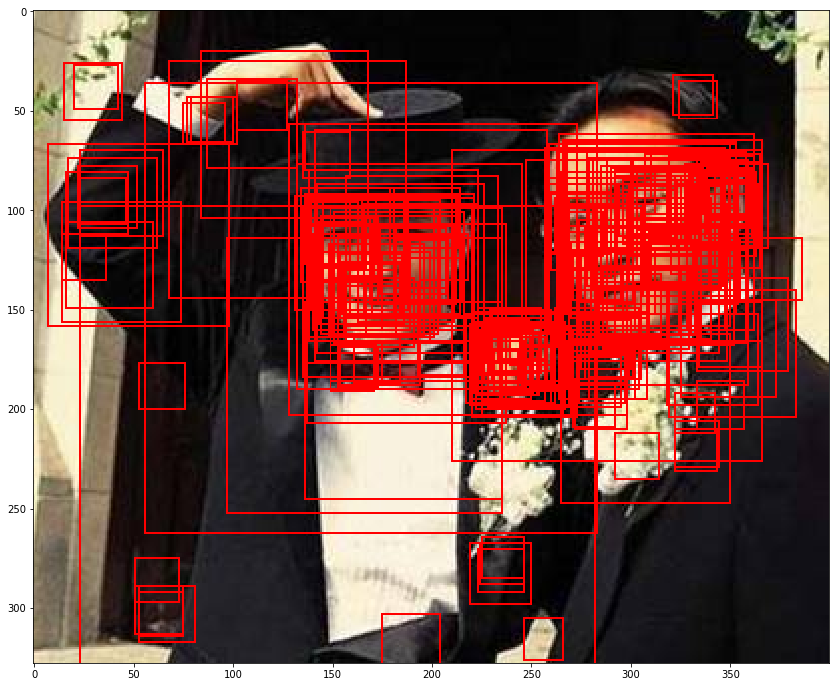

In [10]:
import matplotlib.pyplot as plt

cv2_img = cv2.imread('images/s_l.jpg')

%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

for i in range(bboxes.shape[0]):
    bbox = bboxes[i, :4]
    cv2.rectangle(cv2_img, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 0, 255),1)
    
cv2_img = cv2_img[:,:,::-1]
plt.imshow(cv2_img, )

## Stage 2

All candidate windows from P-net will feed into R-Net. The first step will be to crop the corresponding patches from test image, and resize them as 24x24. 

The function "correct_bboxes" will take the upstream bounding boxes and tailor them if they are outside the test image. return the cutout cooridnates, the cooridnates of bounding boxes on the test image.

In [11]:
def correct_bboxes(bboxes, width, height):
    """Crop boxes that are too big and get coordinates
    with respect to cutouts.

    Arguments:
        bboxes: a float numpy array of shape [n, 5],
            where each row is (xmin, ymin, xmax, ymax, score).
        width: a float number.
        height: a float number.

    Returns:
        dy, dx, edy, edx: a int numpy arrays of shape [n],
            coordinates of the boxes with respect to the cutouts.
        y, x, ey, ex: a int numpy arrays of shape [n],
            corrected ymin, xmin, ymax, xmax.
        h, w: a int numpy arrays of shape [n],
            just heights and widths of boxes.

        in the following order:
            [dy, edy, dx, edx, y, ey, x, ex, w, h].
    """
    x1, y1, x2, y2 = [bboxes[:, i] for i in range(4)]
    w, h = x2 - x1 + 1.0,  y2 - y1 + 1.0
    num_boxes = bboxes.shape[0]

    # 'e' stands for end
    # (x, y) -> (ex, ey)
    x, y, ex, ey = x1, y1, x2, y2

    # we need to cut out a box from the image.
    # (x, y, ex, ey) are corrected coordinates of the box
    # in the image.
    # (dx, dy, edx, edy) are coordinates of the box in the cutout
    # from the image.
    dx, dy = np.zeros((num_boxes,)), np.zeros((num_boxes,))
    edx, edy = w.copy() - 1.0, h.copy() - 1.0

    # if box's bottom right corner is too far right
    ind = np.where(ex > width - 1.0)[0]
    edx[ind] = w[ind] + width - 2.0 - ex[ind]
    ex[ind] = width - 1.0

    # if box's bottom right corner is too low
    ind = np.where(ey > height - 1.0)[0]
    edy[ind] = h[ind] + height - 2.0 - ey[ind]
    ey[ind] = height - 1.0

    # if box's top left corner is too far left
    ind = np.where(x < 0.0)[0]
    dx[ind] = 0.0 - x[ind]
    x[ind] = 0.0

    # if box's top left corner is too high
    ind = np.where(y < 0.0)[0]
    dy[ind] = 0.0 - y[ind]
    y[ind] = 0.0

    return_list = [dy, edy, dx, edx, y, ey, x, ex, w, h]
    return_list = [i.astype('int32') for i in return_list]

    return return_list

All the patches feed into R-Net. The bounding boxes will be further filtered using the face score, NMS.

The left bounding boxes will be repeatly calibrated and converted to square form  

In [12]:
size = 24
num_boxes = len(bboxes)
[dy, edy, dx, edx, y, ey, x, ex, w, h] = correct_bboxes(bboxes, width, height)

img_boxes = np.zeros((num_boxes, 3, size, size))

for i in range(num_boxes):
    img_box = np.zeros((h[i], w[i], 3))

    img_box[dy[i]:(edy[i] + 1), dx[i]:(edx[i] + 1), :] =\
        image[y[i]:(ey[i] + 1), x[i]:(ex[i] + 1), :]

    # resize
    img_box = cv2.resize(img_box, (size, size), interpolation=cv2.INTER_LINEAR)
    
    img_boxes[i, :, :, :] = preprocess(img_box)

img_boxes = torch.FloatTensor(img_boxes).to(device)
offset, prob = rnet(img_boxes)
offsets = offset.cpu().data.numpy()  # shape [n_boxes, 4]
probs = prob.cpu().data.numpy()  # shape [n_boxes, 2]

keep = np.where(probs[:, 1] > thresholds[1])[0]
bboxes = bboxes[keep]
bboxes[:, 4] = probs[keep, 1].reshape((-1,)) # assign score from stage 2
offsets = offsets[keep] #

keep = nms(bboxes, nms_thresholds[1])
bboxes = bboxes[keep]
bboxes = calibrate_box(bboxes, offsets[keep])
bboxes = convert_to_square(bboxes)
bboxes[:, 0:4] = np.round(bboxes[:, 0:4])

bboxes.shape

(25, 5)

### Vasualize the filtered candidate windows from RNet

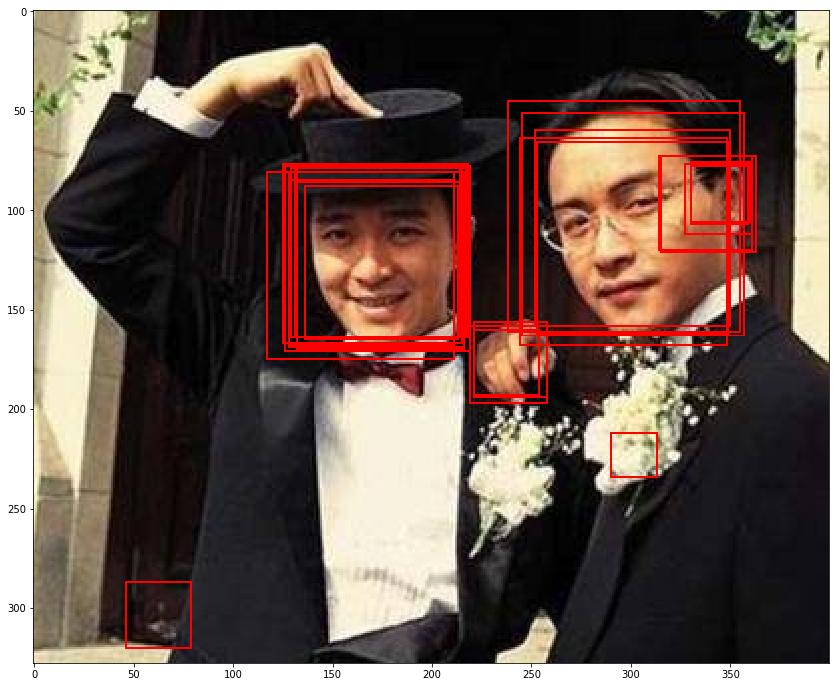

In [13]:
cv2_img = cv2.imread('images/s_l.jpg')

%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

for i in range(bboxes.shape[0]):
    bbox = bboxes[i, :4]
    cv2.rectangle(cv2_img, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 0, 255),1)
    
cv2_img = cv2_img[:,:,::-1]
plt.imshow(cv2_img, )

## Stage 3

With the same procedure of stage 2, stage 3 will first crop the leftover patches from test image, and resize them as 48x48. O-Net will output the final predictions. Facial landmarks' positions will be predicted in this net

In [14]:
size = 48
num_boxes = len(bboxes)
[dy, edy, dx, edx, y, ey, x, ex, w, h] = correct_bboxes(bboxes, width, height)

img_boxes = np.zeros((num_boxes, 3, size, size))

for i in range(num_boxes):
    img_box = np.zeros((h[i], w[i], 3))

    img_box[dy[i]:(edy[i] + 1), dx[i]:(edx[i] + 1), :] =\
        image[y[i]:(ey[i] + 1), x[i]:(ex[i] + 1), :]

    # resize
    img_box = cv2.resize(img_box, (size, size), interpolation=cv2.INTER_LINEAR)

    img_boxes[i, :, :, :] = preprocess(img_box)

img_boxes = torch.FloatTensor(img_boxes).to(device)
landmark, offset, prob = onet(img_boxes)
landmarks = landmark.cpu().data.numpy()  # shape [n_boxes, 10]
offsets = offset.cpu().data.numpy()  # shape [n_boxes, 4]
probs = prob.cpu().data.numpy()  # shape [n_boxes, 2]

keep = np.where(probs[:, 1] > thresholds[2])[0]
bboxes = bboxes[keep]
bboxes[:, 4] = probs[keep, 1].reshape((-1,)) # assign score from stage 2
offsets = offsets[keep] 
landmarks = landmarks[keep]

# compute landmark points
width = bboxes[:, 2] - bboxes[:, 0] + 1.0
height = bboxes[:, 3] - bboxes[:, 1] + 1.0
xmin, ymin = bboxes[:, 0], bboxes[:, 1]
landmarks[:, 0:5] = np.expand_dims(xmin, 1) + np.expand_dims(width, 1) * landmarks[:, 0:5]
landmarks[:, 5:10] = np.expand_dims(ymin, 1) + np.expand_dims(height, 1) * landmarks[:, 5:10]

bboxes = calibrate_box(bboxes, offsets)
keep = nms(bboxes, nms_thresholds[2], mode='min')
bboxes = bboxes[keep]
landmarks = landmarks[keep]

bboxes.shape

(2, 5)

### Vasualize the final detection 

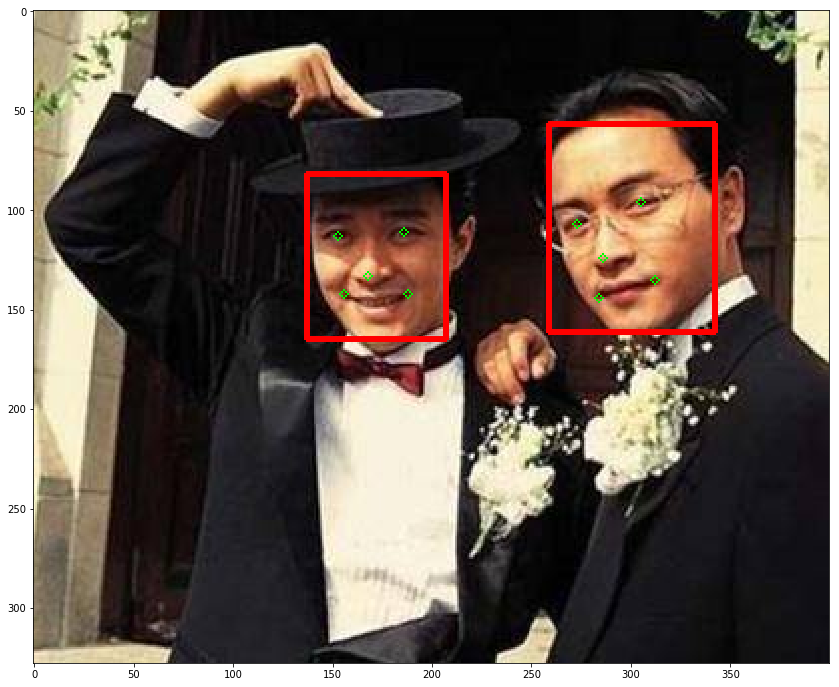

In [15]:
cv2_img = cv2.imread('images/s_l.jpg')

%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

for i in range(bboxes.shape[0]):
    bbox = bboxes[i, :4]
    cv2.rectangle(cv2_img, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 0, 255),2)

for i in range(landmarks.shape[0]):
    landmarks_one = landmarks[i, :]
    landmarks_one = landmarks_one.reshape(2, 5).T
    for j in range(5):
        cv2.circle(cv2_img, (int(landmarks_one[j, 0]), int(landmarks_one[j, 1])), 2, (0, 255, 0),1)
    
cv2_img = cv2_img[:,:,::-1]
plt.imshow(cv2_img, )